In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
us_pollution_dataset = pd.read_csv('US_Pollution_2000_2023.csv')

In [3]:
us_pollution_dataset.head()

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58


In [4]:
us_pollution_dataset.columns

Index(['Unnamed: 0', 'Date', 'Address', 'State', 'County', 'City', 'O3 Mean',
       'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'CO Mean',
       'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'SO2 Mean',
       'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI'],
      dtype='object')

In [5]:
us_pollution_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665414 entries, 0 to 665413
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         665414 non-null  int64  
 1   Date               665414 non-null  object 
 2   Address            665414 non-null  object 
 3   State              665414 non-null  object 
 4   County             665414 non-null  object 
 5   City               665414 non-null  object 
 6   O3 Mean            665414 non-null  float64
 7   O3 1st Max Value   665414 non-null  float64
 8   O3 1st Max Hour    665414 non-null  int64  
 9   O3 AQI             665414 non-null  int64  
 10  CO Mean            665414 non-null  float64
 11  CO 1st Max Value   665414 non-null  float64
 12  CO 1st Max Hour    665414 non-null  int64  
 13  CO AQI             665414 non-null  float64
 14  SO2 Mean           665414 non-null  float64
 15  SO2 1st Max Value  665414 non-null  float64
 16  SO

In [6]:
us_pollution_dataset['Date'] = pd.to_datetime(us_pollution_dataset['Date'])

In [7]:
us_pollution_dataset.drop('Unnamed: 0', axis = 1, inplace = True)

In [8]:
null_rows = us_pollution_dataset[us_pollution_dataset.isnull().any(axis = 1)]
null_rows

,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI


In [9]:
null_data_subgroup = us_pollution_dataset[(us_pollution_dataset['State'] == 'California') & (us_pollution_dataset['County'] == 'Solano') & (us_pollution_dataset['City'] == 'Vallejo')]
null_data_subgroup

,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
8845,2000-01-01,304 TUOLUMNE ST.,California,Solano,Vallejo,0.016882,0.025,15,23,0.327778,...,6,6.0,1.045455,3.0,11,4.0,12.260870,26.0,1,25
8846,2000-01-02,304 TUOLUMNE ST.,California,Solano,Vallejo,0.016059,0.027,11,25,0.775000,...,8,20.0,1.409091,3.0,5,4.0,16.826087,28.0,1,26
8847,2000-01-03,304 TUOLUMNE ST.,California,Solano,Vallejo,0.005294,0.009,8,8,1.687500,...,8,32.0,3.000000,4.0,7,6.0,29.260870,39.0,17,37
8848,2000-01-04,304 TUOLUMNE ST.,California,Solano,Vallejo,0.002765,0.007,11,6,2.075000,...,3,35.0,2.590909,3.0,0,4.0,30.043478,40.0,17,38
8849,2000-01-05,304 TUOLUMNE ST.,California,Solano,Vallejo,0.004545,0.010,13,9,1.506250,...,23,34.0,1.882353,4.0,20,6.0,28.555556,46.0,20,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653833,2023-07-27,304 TUOLUMNE ST.,California,Solano,Vallejo,0.022412,0.025,10,23,0.283333,...,0,3.0,0.109091,0.3,11,0.0,2.586364,3.6,6,3
653834,2023-07-28,304 TUOLUMNE ST.,California,Solano,Vallejo,0.022235,0.027,10,25,0.291667,...,0,3.0,0.186364,0.3,15,0.0,3.213636,7.7,5,7
653835,2023-07-29,304 TUOLUMNE ST.,California,Solano,Vallejo,0.021059,0.027,10,25,0.300000,...,0,3.0,0.322727,0.7,9,0.0,2.659091,6.1,21,6
653836,2023-07-30,304 TUOLUMNE ST.,California,Solano,Vallejo,0.021588,0.028,10,26,0.300000,...,0,3.0,0.263636,0.5,9,0.0,2.809091,4.5,19,4


In [10]:
mean_null_data_subgroup = null_data_subgroup.mean()
mean_null_data_subgroup

<ipython-input-10-3dd9b3d54924>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_null_data_subgroup = null_data_subgroup.mean()
<ipython-input-10-3dd9b3d54924>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_null_data_subgroup = null_data_subgroup.mean()


O3 Mean               0.024007
O3 1st Max Value      0.031857
O3 1st Max Hour      10.829055
O3 AQI               29.808470
CO Mean               0.421130
CO 1st Max Value      0.631267
CO 1st Max Hour       6.318822
CO AQI                7.145865
SO2 Mean              0.857558
SO2 1st Max Value     1.867219
SO2 1st Max Hour      8.622501
SO2 AQI               2.148705
NO2 Mean              9.550049
NO2 1st Max Value    18.981687
NO2 1st Max Hour     12.083402
NO2 AQI              17.698450
dtype: float64

In [11]:
us_pollution_dataset.fillna(mean_null_data_subgroup, inplace = True)

In [12]:
us_pollution_dataset.describe()

,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
count,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000
mean,0.028605,0.038980,10.766409,39.137872,0.329459,0.465604,5.922553,5.247399,1.428759,3.931057,8.867280,5.154743,11.510561,23.253519,11.588897,21.766209
std,0.012151,0.014912,3.297315,22.253413,0.275725,0.434542,7.719537,5.010467,2.410071,7.700799,6.776779,10.371465,8.957527,15.264335,7.888301,14.447780
min,-0.000706,0.000000,7.000000,0.000000,-0.437500,-0.400000,0.000000,0.000000,-2.508333,-2.300000,0.000000,0.000000,-4.629167,-4.400000,0.000000,0.000000
25%,0.019824,0.029000,9.000000,27.000000,0.175000,0.200000,0.000000,2.000000,0.173913,0.600000,3.000000,0.000000,4.860870,11.000000,5.000000,10.000000
50%,0.028353,0.038000,10.000000,35.000000,0.258333,0.300000,1.000000,3.000000,0.604167,1.400000,8.000000,1.000000,9.304348,21.000000,9.000000,20.000000
75%,0.036882,0.048000,11.000000,44.000000,0.408696,0.600000,9.000000,7.000000,1.604545,4.000000,13.000000,6.000000,15.958333,33.000000,20.000000,31.000000
max,0.107353,0.140000,23.000000,237.000000,7.508333,15.500000,23.000000,201.000000,321.625000,351.000000,23.000000,200.000000,140.650000,371.700000,23.000000,153.000000


In [13]:
print('Unique State Count:', us_pollution_dataset['State'].nunique())
print('Unique County Count:', us_pollution_dataset['County'].nunique())
print('Unique City Count:', us_pollution_dataset['City'].nunique())

Unique State Count: 48
Unique County Count: 137
Unique City Count: 150


In [14]:
print('Unique Years in the dataset:\n', us_pollution_dataset.Date.unique())

Unique Years in the dataset:
 ['2000-01-01T00:00:00.000000000' '2000-01-02T00:00:00.000000000'
 '2000-01-03T00:00:00.000000000' ... '2023-09-28T00:00:00.000000000'
 '2023-09-29T00:00:00.000000000' '2023-09-30T00:00:00.000000000']


In [15]:
mean_columns = [column for column in us_pollution_dataset.columns if 'Mean' in column]
hour_columns = [column for column in us_pollution_dataset.columns if 'Hour' in column]
value_columns = [column for column in us_pollution_dataset.columns if 'Value' in column]
aqi_columns = [column for column in us_pollution_dataset.columns if 'AQI' in column]

category_columns = dict(mean = mean_columns, hour = hour_columns, value = value_columns, aqi = aqi_columns)

# Heatmap Analysis

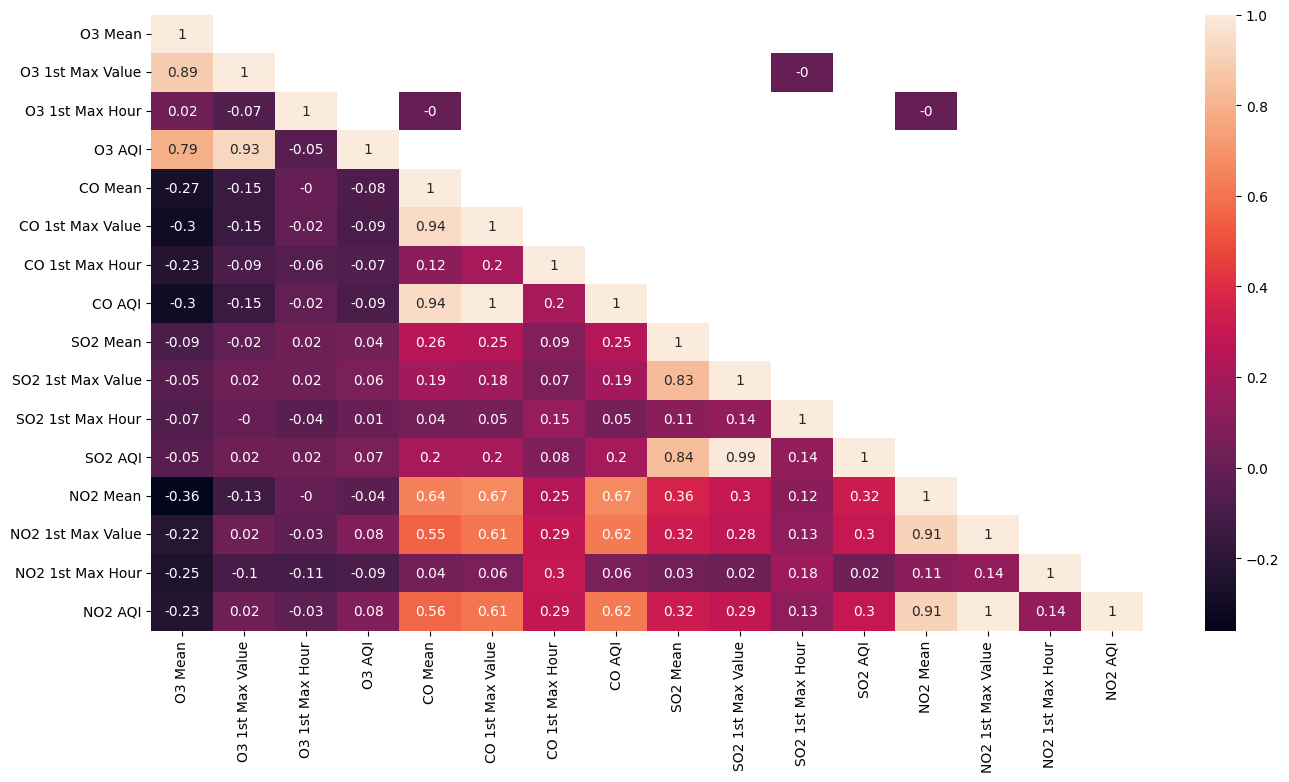

In [16]:
plt.figure(figsize = (16, 8))
correlation_matrix = us_pollution_dataset.drop(columns = ['Date']).corr(numeric_only = True).round(2)
sns.heatmap(correlation_matrix, annot = True, cmap = 'rocket', mask = np.triu(correlation_matrix, 1))
plt.show()

# Detailed Heatmap Analysis

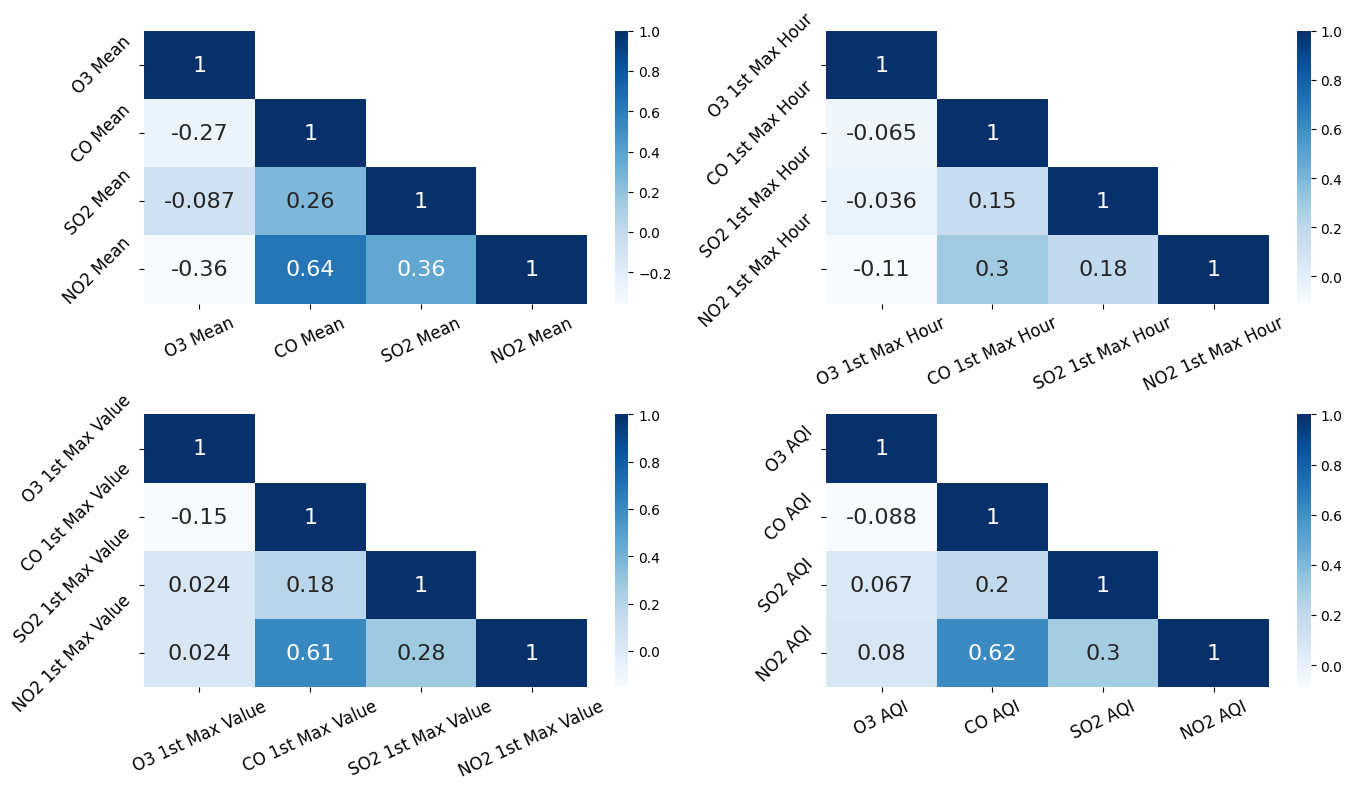

In [17]:
fig, ax = plt.subplots(2, 2, figsize = (14, 8))
ax = ax.flatten()

for i, columns in enumerate(category_columns.values()):
  correlation_matrix = us_pollution_dataset[columns].corr(numeric_only = True)
  sns.heatmap(correlation_matrix, annot = True, cmap = 'Blues', mask = np.triu(correlation_matrix, 1), annot_kws = {"size": 16}, ax = ax[i])
  ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation = 45, fontsize = 12)
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = 25, fontsize = 12)

plt.tight_layout()
plt.show()

# Distribution Analysis

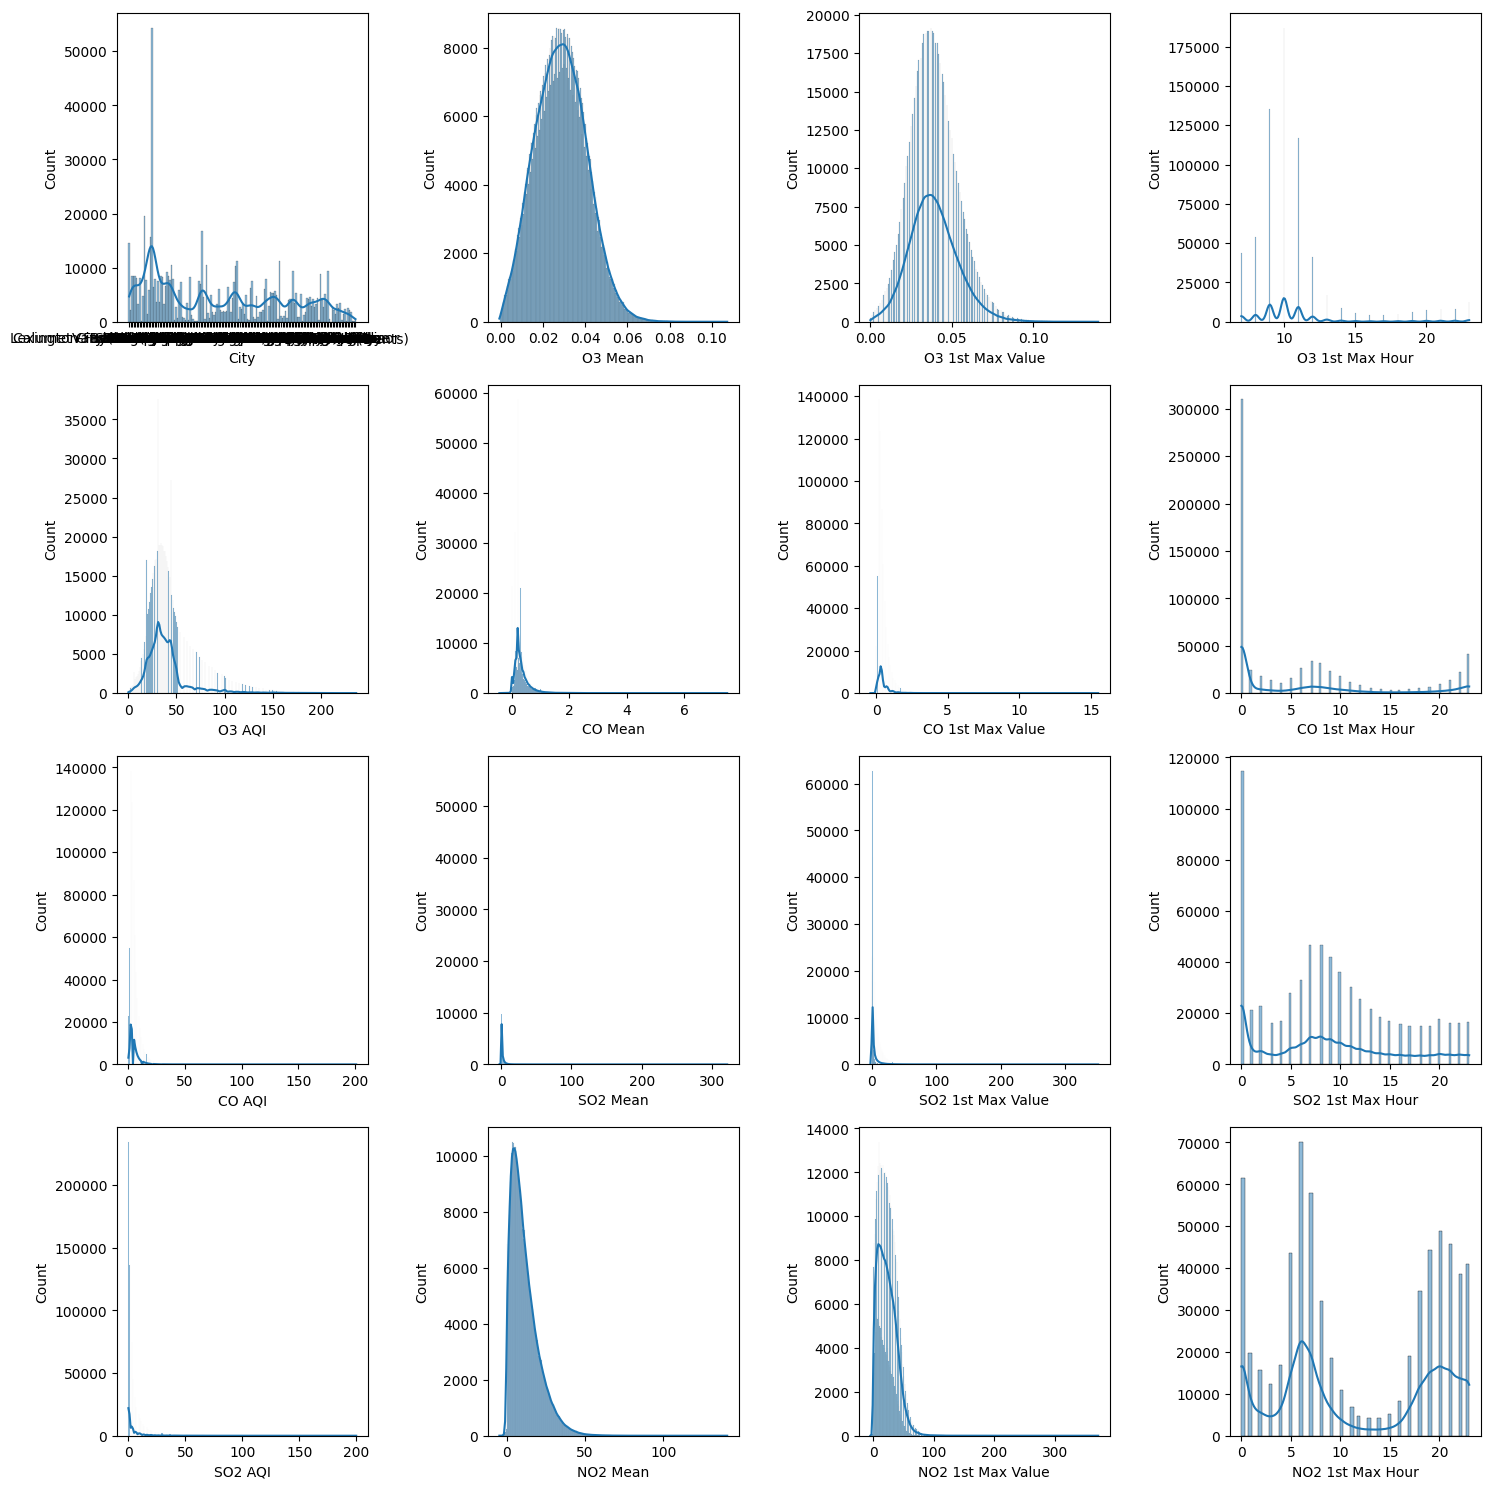

In [18]:
fig, ax = plt.subplots(4, 4, figsize = (15, 15))
ax = ax.flatten()

for i, column in enumerate(us_pollution_dataset.iloc[:, 4:20]):
  sns.histplot(us_pollution_dataset[column], ax = ax[i], kde = True)

plt.tight_layout()
plt.show()

# Boxplot Analysis

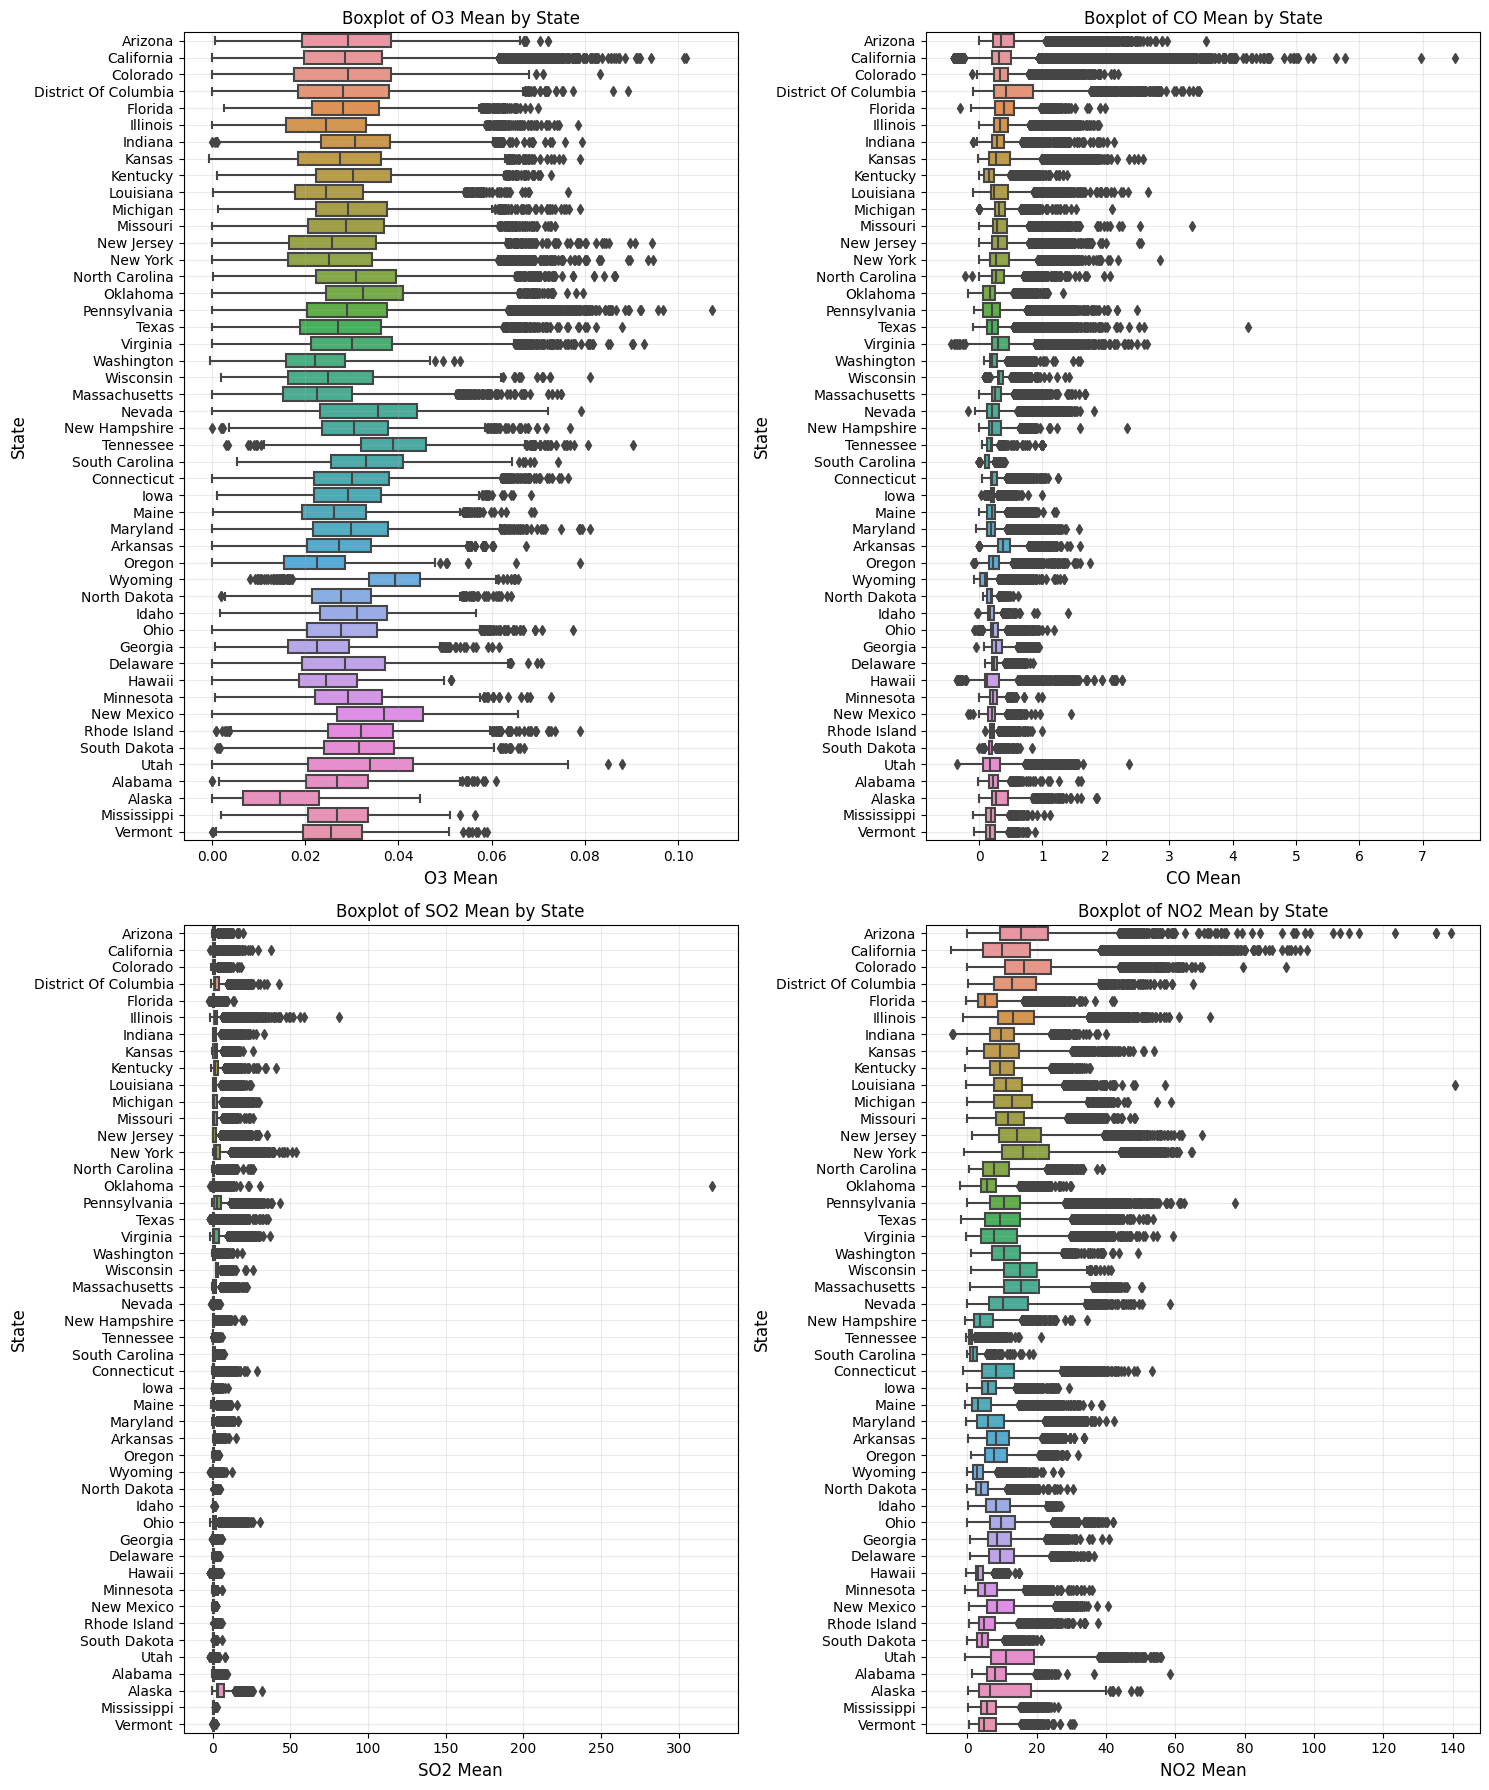

In [19]:
fig, ax = plt.subplots(2, 2, figsize = (15, 18))
ax = ax.flatten()

for i, column in enumerate(mean_columns):
  sns.boxplot(x = us_pollution_dataset[column], y = us_pollution_dataset['State'], data = us_pollution_dataset, ax = ax[i], orient = 'h')
  ax[i].set_title(f"Boxplot of {column} by State", fontsize = 12)
  ax[i].set_ylabel("State", fontsize = 12)
  ax[i].set_xlabel(column, fontsize = 12)
  ax[i].tick_params(axis = 'x', rotation = 0, labelsize = 10)
  ax[i].grid(alpha = 0.25)

plt.tight_layout()
plt.show()

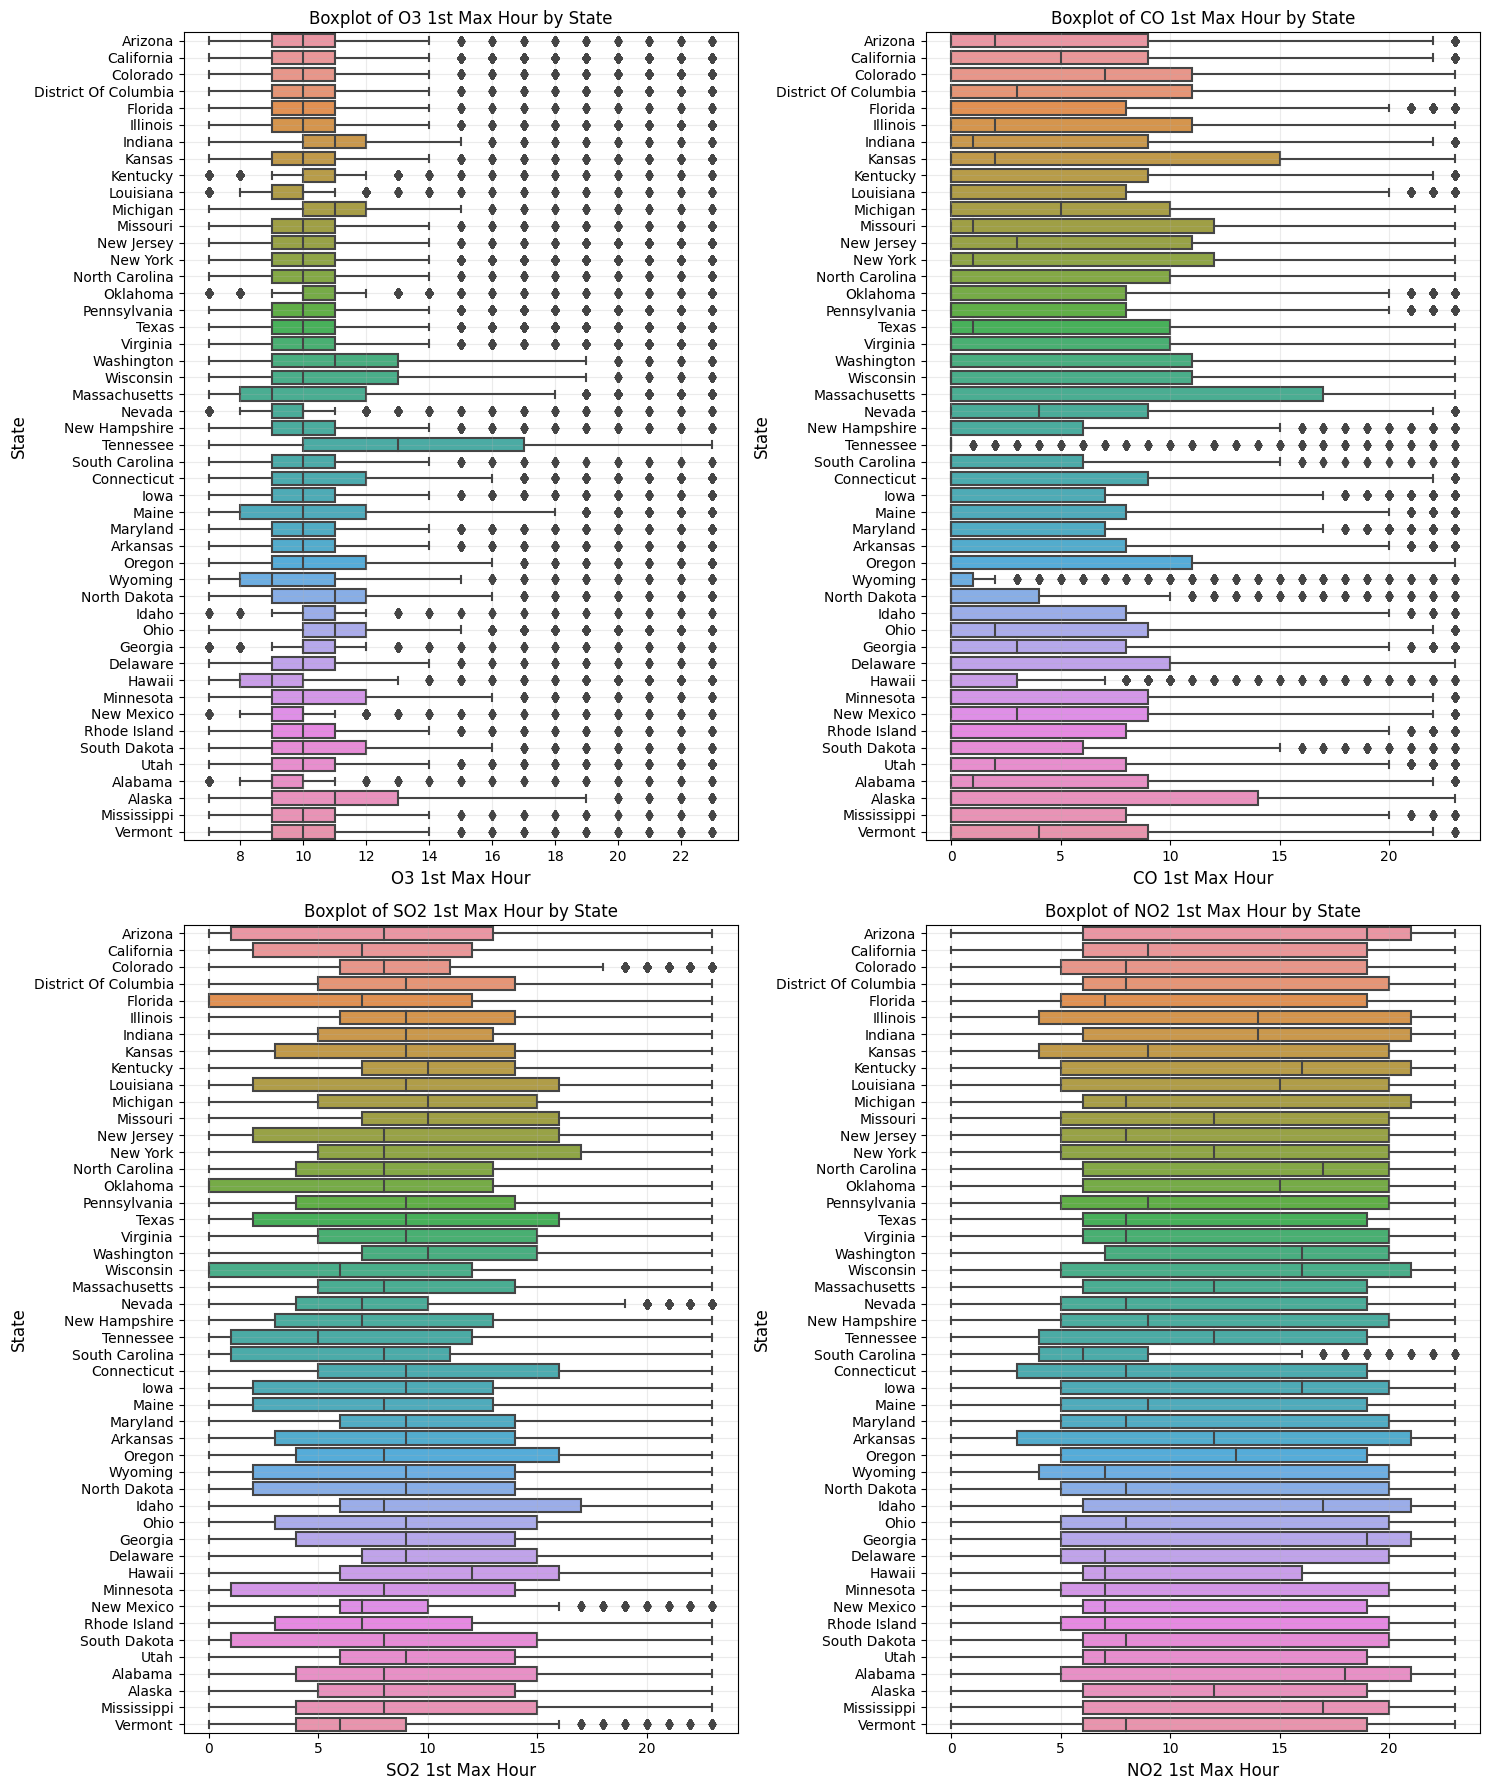

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (15, 18))
ax = ax.flatten()

for i, column in enumerate(hour_columns):
  sns.boxplot(x = us_pollution_dataset[column], y = us_pollution_dataset['State'], data = us_pollution_dataset, ax = ax[i], orient = 'h')
  ax[i].set_title(f"Boxplot of {column} by State", fontsize = 12)
  ax[i].set_ylabel("State", fontsize = 12)
  ax[i].set_xlabel(column, fontsize = 12)
  ax[i].tick_params(axis = 'x', rotation = 0, labelsize = 10)
  ax[i].grid(alpha = 0.25)

plt.tight_layout()
plt.show()

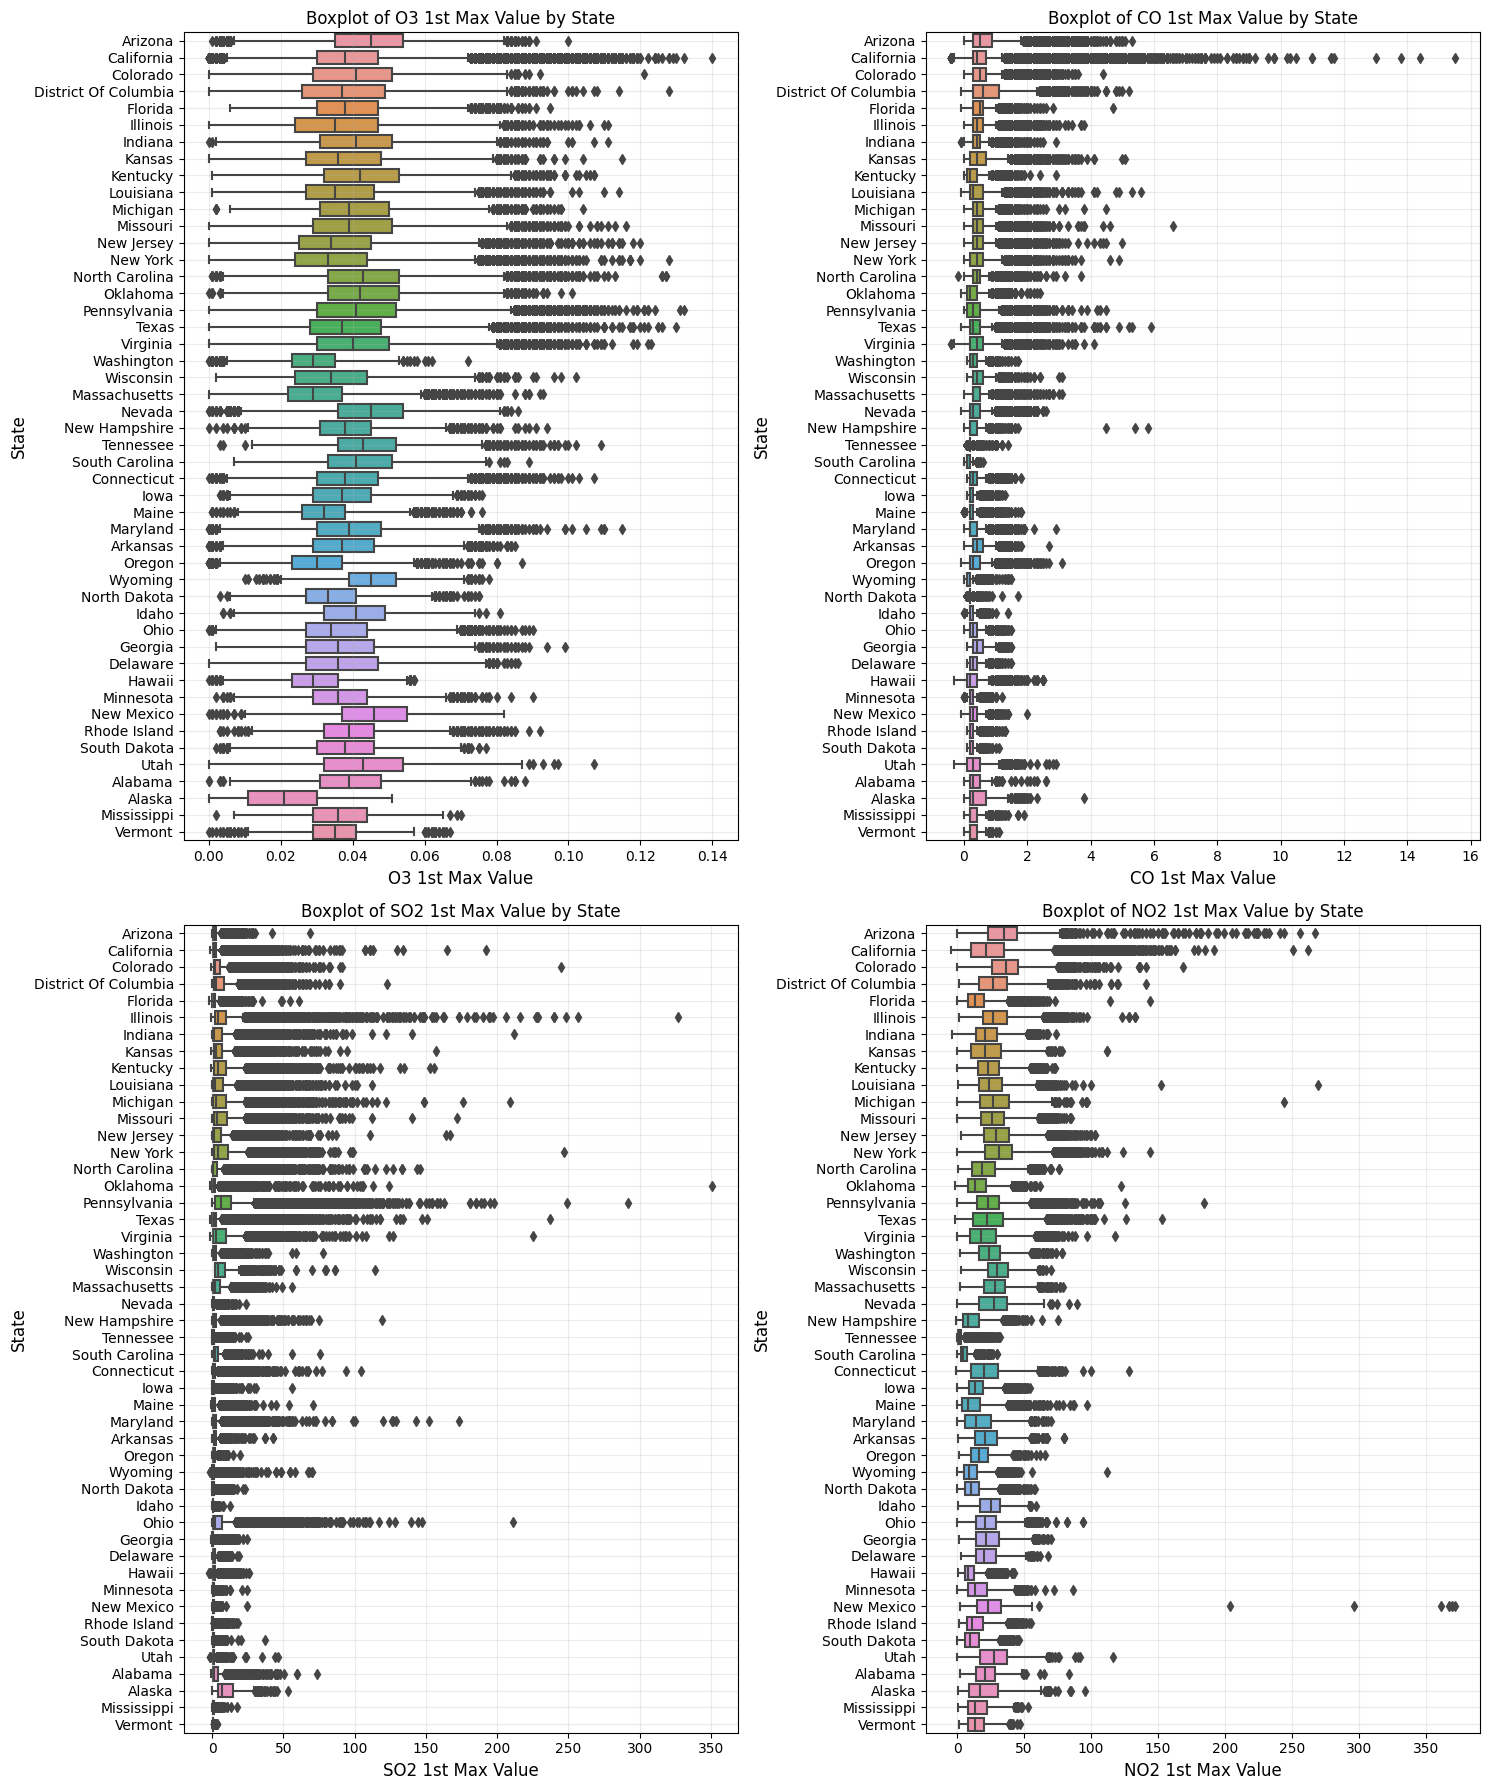

In [21]:
fig, ax = plt.subplots(2, 2, figsize = (15, 18))
ax = ax.flatten()

for i, column in enumerate(value_columns):
  sns.boxplot(x = us_pollution_dataset[column], y = us_pollution_dataset['State'], data = us_pollution_dataset, ax = ax[i], orient = 'h')
  ax[i].set_title(f"Boxplot of {column} by State", fontsize = 12)
  ax[i].set_ylabel("State", fontsize = 12)
  ax[i].set_xlabel(column, fontsize = 12)
  ax[i].tick_params(axis = 'x', rotation = 0, labelsize = 10)
  ax[i].grid(alpha = 0.25)

plt.tight_layout()
plt.show()

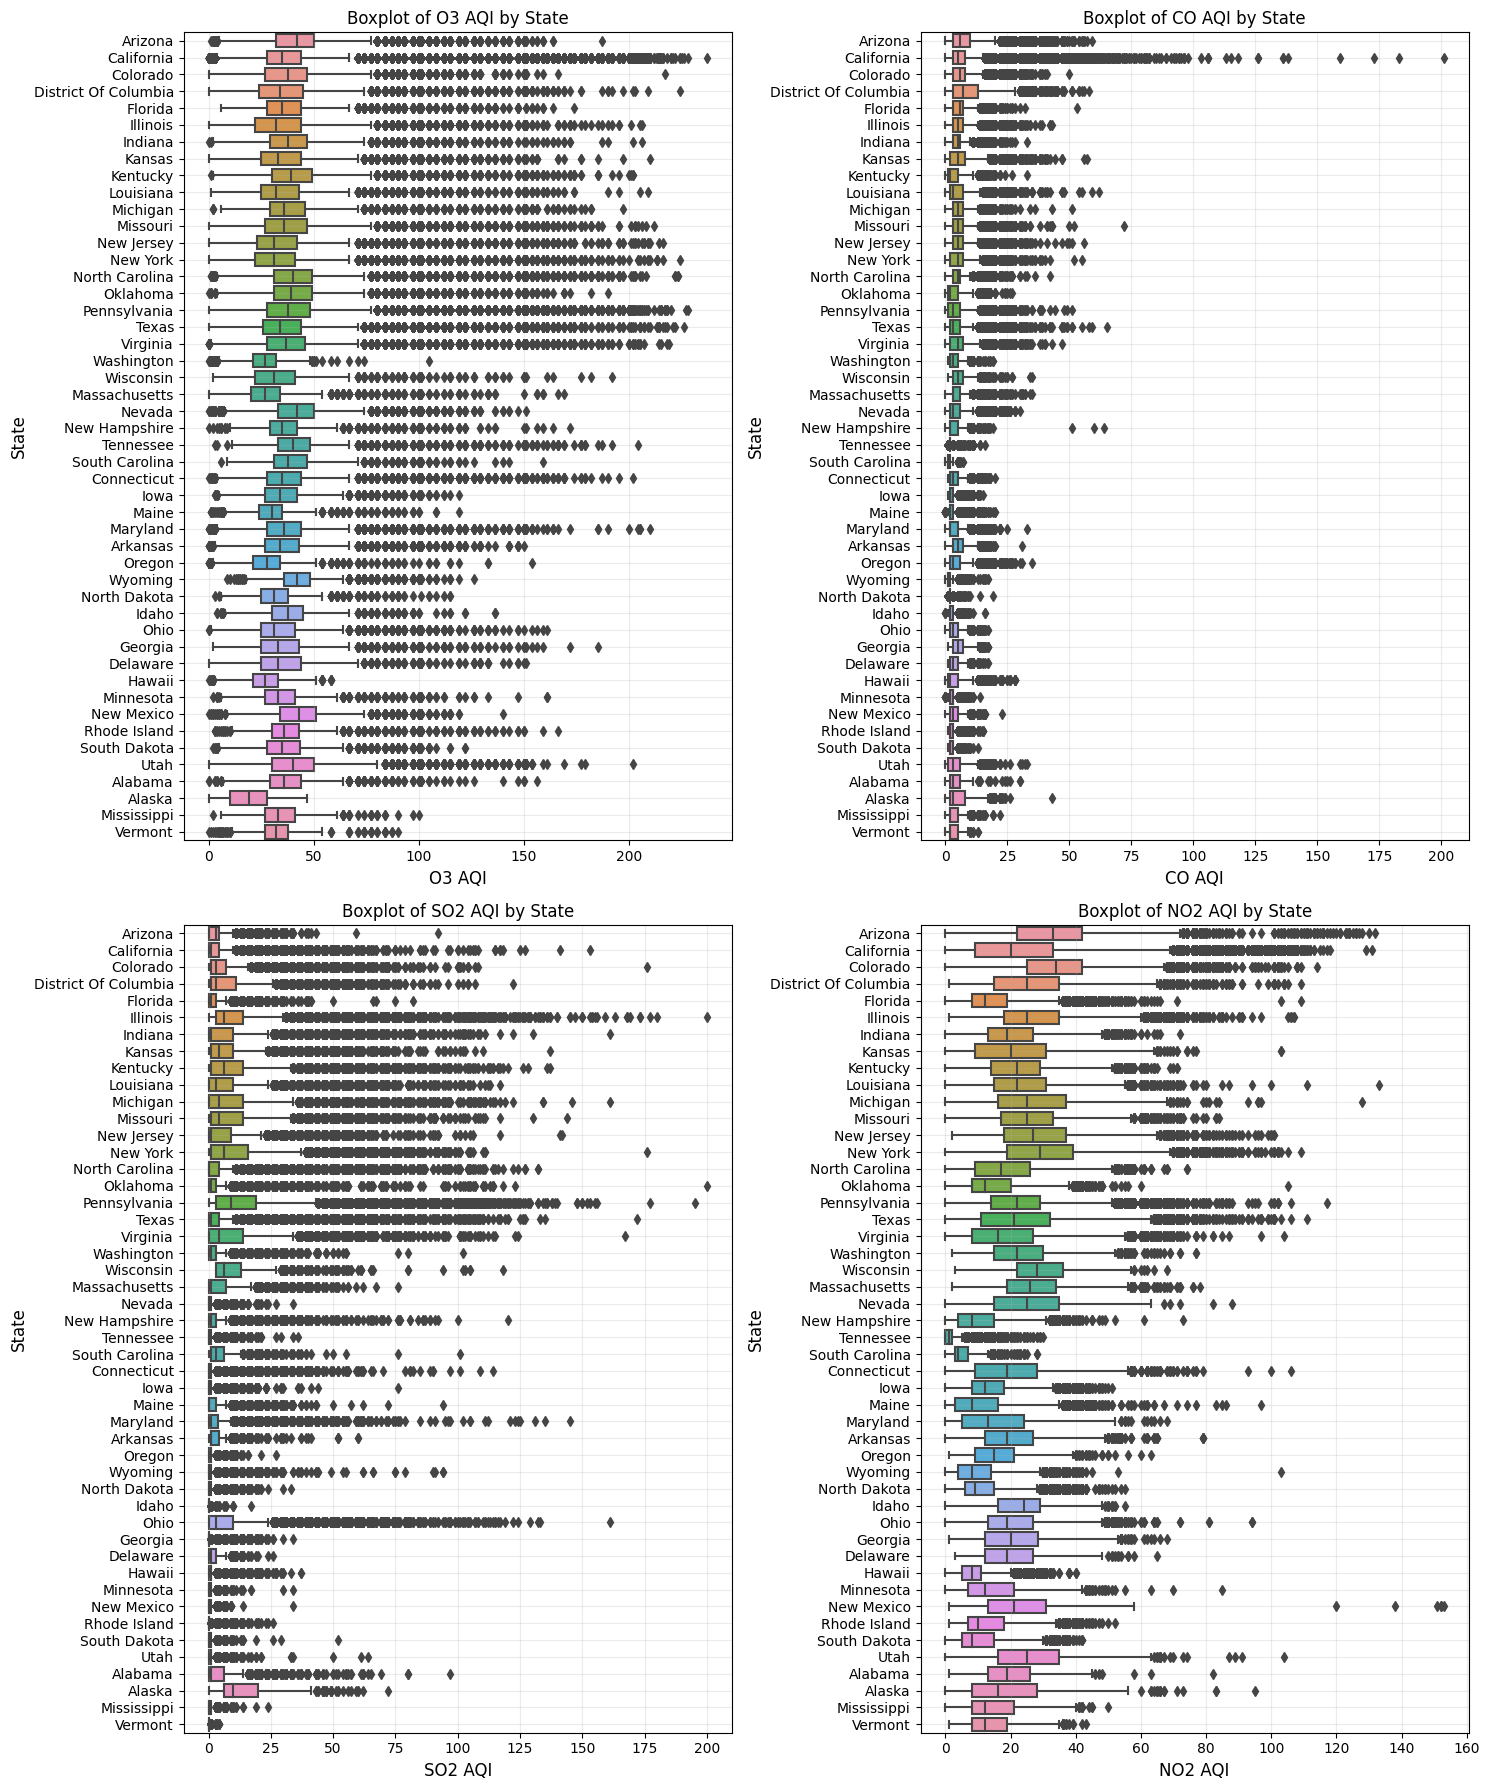

In [22]:
fig, ax = plt.subplots(2, 2, figsize = (15, 18))
ax = ax.flatten()

for i, column in enumerate(aqi_columns):
  sns.boxplot(x = us_pollution_dataset[column], y = us_pollution_dataset['State'], data = us_pollution_dataset, ax = ax[i], orient = 'h')
  ax[i].set_title(f"Boxplot of {column} by State", fontsize = 12)
  ax[i].set_ylabel("State", fontsize = 12)
  ax[i].set_xlabel(column, fontsize = 12)
  ax[i].tick_params(axis = 'x', rotation = 0, labelsize = 10)
  ax[i].grid(alpha = 0.25)

plt.tight_layout()
plt.show()

# RNN Model

In [23]:
us_pollution_dataset.set_index('Date', inplace=True)

In [24]:
o3_mean = us_pollution_dataset['O3 Mean']

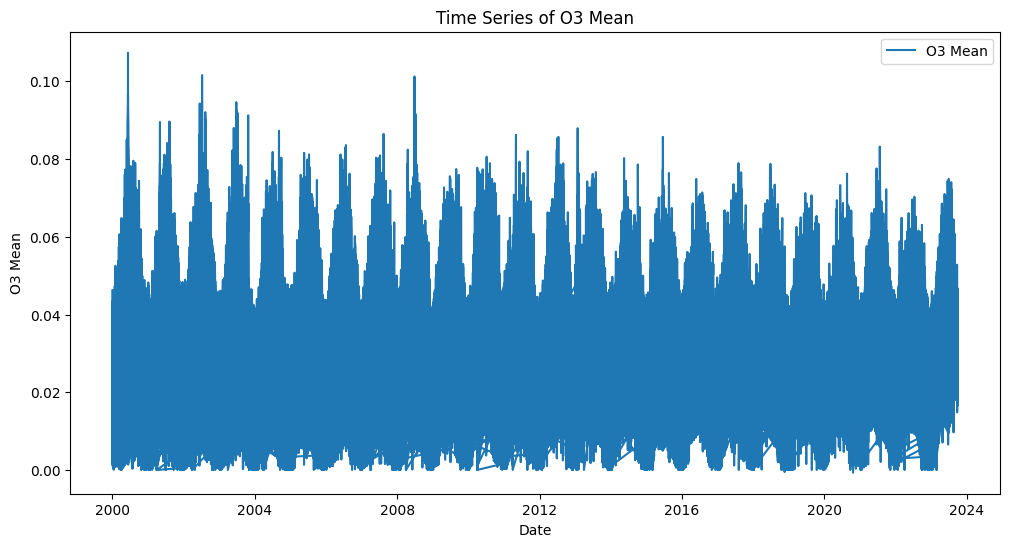

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(o3_mean, label = 'O3 Mean')
plt.title('Time Series of O3 Mean')
plt.xlabel('Date')
plt.ylabel('O3 Mean')
plt.legend()
plt.show()

In [26]:
data = o3_mean.values.reshape(-1, 1)

In [27]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

sequence_length = 10

X, y = create_sequences(data_scaled, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=16))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
  908/16636 [>.............................] - ETA: 1:42 - loss: 0.0069

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions_scaled = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_scaled)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(o3_mean.index[-len(predictions):], y_test, label='Actual CO2 Concentration')
plt.plot(o3_mean.index[-len(predictions):], predictions, label='Predicted CO2 Concentration', color='red')
plt.title('Actual vs Predicted CO2 Concentration (Test Set)')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.legend()
plt.show()

# Mann-Kendall Test

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
numerical_columns = us_pollution_dataset.select_dtypes(include=['float64', 'int64']).columns
numerical_columns